# YOLOV5

## data

[archive.zip](https://www.kaggle.com/datasets/andrewmvd/face-mask-detection)  
├── annotations  
└── images

In [1]:
# !unzip -q archive.zip

## Git Clone

In [4]:
!git clone https://github.com/ultralytics/yolov5  # clone
!pip install -qr yolov5/requirements.txt  # install

Cloning into 'yolov5'...
remote: Enumerating objects: 13286, done.
remote: Total 13286 (delta 0), reused 0 (delta 0), pack-reused 13286
Receiving objects: 100% (13286/13286), 11.98 MiB | 14.43 MiB/s, done.
Resolving deltas: 100% (9254/9254), done.
     |████████████████████████████████| 596 kB 5.4 MB/s 


In [5]:
import pandas as pd
import numpy as np
import os
import glob
from datetime import datetime
import xml.etree.ElementTree as ET 
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

## データの前処理

In [6]:
annotations_path = '/content/annotations'

In [7]:
dataset = {
            'file':[],
            'name':[],    
            'width':[],
            'height':[],
            'xmin':[],
            'ymin':[],   
            'xmax':[],
            'ymax':[],
           }

In [8]:
for anno in glob.glob(annotations_path+'/*.xml'):
    tree = ET.parse(anno)
    
    for elem in tree.iter():
        if 'size' in elem.tag:
            for attr in list(elem):
                if 'width' in attr.tag: 
                    width = int(round(float(attr.text)))
                if 'height' in attr.tag:
                    height = int(round(float(attr.text)))    

        if 'object' in elem.tag:
            for attr in list(elem):
                
                if 'name' in attr.tag:
                    name = attr.text                 
                    dataset['name']+=[name]
                    dataset['width']+=[width]
                    dataset['height']+=[height] 
                    dataset['file']+=[anno.split('/')[-1][0:-4]] 
                            
                if 'bndbox' in attr.tag:
                    for dim in list(attr):
                        if 'xmin' in dim.tag:
                            xmin = int(round(float(dim.text)))
                            dataset['xmin']+=[xmin]
                        if 'ymin' in dim.tag:
                            ymin = int(round(float(dim.text)))
                            dataset['ymin']+=[ymin]                                
                        if 'xmax' in dim.tag:
                            xmax = int(round(float(dim.text)))
                            dataset['xmax']+=[xmax]                                
                        if 'ymax' in dim.tag:
                            ymax = int(round(float(dim.text)))
                            dataset['ymax']+=[ymax]

In [9]:
df = pd.DataFrame(dataset)
df.head()

,file,name,width,height,xmin,ymin,xmax,ymax
0,maksssksksss78,with_mask,301,400,108,231,186,336
1,maksssksksss116,with_mask,400,225,116,88,150,122
2,maksssksksss116,with_mask,400,225,160,79,193,118
3,maksssksksss116,with_mask,400,225,235,43,272,87
4,maksssksksss116,with_mask,400,225,304,68,336,102


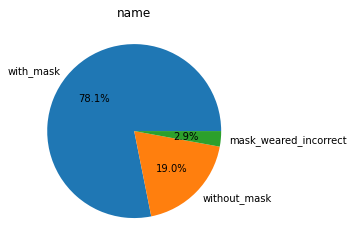

In [10]:
x = df['name'].value_counts()
plt.title('name')
plt.pie(x, labels=x.index, autopct='%.1f%%');

In [11]:
name_dict = {
    'with_mask': 0,
    'mask_weared_incorrect': 1,
    'without_mask': 2 
}

In [12]:
df['class'] = df['name'].map(name_dict)
df.head()

,file,name,width,height,xmin,ymin,xmax,ymax,class
0,maksssksksss78,with_mask,301,400,108,231,186,336,0
1,maksssksksss116,with_mask,400,225,116,88,150,122,0
2,maksssksksss116,with_mask,400,225,160,79,193,118,0
3,maksssksksss116,with_mask,400,225,235,43,272,87,0
4,maksssksksss116,with_mask,400,225,304,68,336,102,0


In [13]:
filenames = [*os.listdir('/content/images')]
len(filenames)

500

In [14]:
# data split
from sklearn.model_selection import train_test_split
train, test = train_test_split(filenames, test_size=0.1, random_state=22)
test, val = train_test_split(test, test_size=0.7, random_state=22)
print('Length of Train =',len(train))
print('='*30)
print('Length of Valid =',len(val))
print('='*30)
print('Length of test =', len(test))

Length of Train = 450
Length of Valid = 35
Length of test = 15


In [15]:
os.mkdir('./yolov5/data/train')
os.mkdir('./yolov5/data/val')
os.mkdir('./yolov5/data/test')
os.mkdir('./yolov5/data/train/images')
os.mkdir('./yolov5/data/train/labels')
os.mkdir('./yolov5/data/test/images')
os.mkdir('./yolov5/data/test/labels')
os.mkdir('./yolov5/data/val/images')
os.mkdir('./yolov5/data/val/labels')

In [18]:
from PIL import Image

def copyImages(imageList, folder_Name):
    for image in imageList:
        img = Image.open('/content/images/'+image)
        img1 = img.resize((640, 640))
        _ = img1.save("./yolov5/data/"+folder_Name+'/images/'+image)

In [19]:
copyImages(train, 'train')
copyImages(val, 'val')
copyImages(test, 'test')

In [20]:
df['xmax'] = (640/df['width'])*df['xmax']
df['ymax'] = (640/df['height'])*df['ymax']
df['xmin'] = (640/df['width'])*df['xmin']
df['ymin'] = (640/df['height'])*df['ymin']

In [21]:
df[['xmax', 'ymax', 'xmin', 'ymin']] = df[['xmax', 'ymax', 'xmin', 'ymin']].astype('int64')

In [22]:
df.head()

,file,name,width,height,xmin,ymin,xmax,ymax,class
0,maksssksksss78,with_mask,301,400,229,369,395,537,0
1,maksssksksss116,with_mask,400,225,185,250,240,347,0
2,maksssksksss116,with_mask,400,225,256,224,308,335,0
3,maksssksksss116,with_mask,400,225,376,122,435,247,0
4,maksssksksss116,with_mask,400,225,486,193,537,290,0


In [23]:
df['x_center'] = (df['xmax']+df['xmin'])/(2*640)
df['y_center'] = (df['ymax']+df['ymin'])/(2*640)
df['box_height'] = (df['xmax']-df['xmin'])/(640)
df['box_width'] = (df['ymax']-df['ymin'])/(640)

In [24]:
df.head()

,file,name,width,height,xmin,ymin,xmax,ymax,class,x_center,y_center,box_height,box_width
0,maksssksksss78,with_mask,301,400,229,369,395,537,0,0.487500,0.707812,0.259375,0.262500
1,maksssksksss116,with_mask,400,225,185,250,240,347,0,0.332031,0.466406,0.085938,0.151562
2,maksssksksss116,with_mask,400,225,256,224,308,335,0,0.440625,0.436719,0.081250,0.173437
3,maksssksksss116,with_mask,400,225,376,122,435,247,0,0.633594,0.288281,0.092188,0.195312
4,maksssksksss116,with_mask,400,225,486,193,537,290,0,0.799219,0.377344,0.079687,0.151562


In [25]:
df = df.astype('string')

In [26]:
def create_labels(image_list, data_name):
    fileNames = [x.split('.')[0] for x in image_list]

    for name in fileNames:
        data = df[df.file==name]
        box_list = []
        
        for index in range(len(data)):
            row = data.iloc[index]
            box_list.append(row['class']+' '+row['x_center']+' '+row['y_center']\
                        +' '+row['box_height']+' '+row['box_width'])
            
        text = '\n'.join(box_list)
        with open('./yolov5/data/'+data_name+'/labels/'+name+'.txt', 'w') as file:
            file.write(text)   

In [27]:
create_labels(train, 'train')
create_labels(val, 'val')
create_labels(test, 'test')

## モデル構築

In [28]:
%cd yolov5

/content/yolov5


In [29]:
import torch
from yolov5 import utils

In [30]:
yaml_text = """train: data/train/images
val: data/train/images

nc: 3
names: ['with_mask', 'mask_weared_incorrect', 'without_mask']"""

In [31]:
with open('data/data.yaml', 'w') as file:
    file.write(yaml_text)

In [32]:
%cat data/data.yaml

train: data/train/images
val: data/train/images

nc: 3
names: ['with_mask', 'mask_weared_incorrect', 'without_mask']

## 学習

In [33]:
start = datetime.now()
!python train.py --img 640 --batch 16 --epochs 100 --data data/data.yaml --weights yolov5s.pt --cache
end = datetime.now()

train: weights=yolov5s.pt, cfg=, data=data/data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=100, batch_size=16, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v6.1-177-gd059d1d torch 1.11.0+cu113 CUDA:0 (Tesla K80, 11441MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamma=0.0, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, degrees=0.0, trans

In [ ]:
print('Runtime =', end-start)

Runtime = 0:37:28.814237


## 推論

In [ ]:
!python detect.py --source data/test/images/ --weight runs/train/exp3/weights/best.pt --name expTestImage --conf 0.4

detect: weights=['runs/train/exp3/weights/best.pt'], source=data/test/images/, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.4, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=expTestImage, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False
YOLOv5 🚀 v6.1-163-gb53917d torch 1.11.0+cu113 CUDA:0 (Tesla K80, 11441MiB)

Fusing layers... 
Model summary: 213 layers, 7018216 parameters, 0 gradients, 15.8 GFLOPs
image 1/25 /content/yolov5/data/test/images/maksssksksss102.png: 480x640 2 with_masks, Done. (0.029s)
image 2/25 /content/yolov5/data/test/images/maksssksksss117.png: 480x640 1 with_mask, Done. (0.029s)
image 3/25 /content/yolov5/data/test/images/maksssksksss121.png: 480x640 7 without_masks, Done. (0.029s)
image 4/25 /content/yolov5/data/test/images/maksssksksss14

## 可視化

In [ ]:
color_dict = {
    'with_mask': (0, 255, 0),
    'mask_weared_incorrect':  (0, 0, 255),
    'without_mask': (255, 0, 0) 
}

In [ ]:
def show_image(img_id):
    df_image = df[df.file==img_id]
    df_image[['xmin', 'ymin', 'xmax', 'ymax']] = df_image[['xmin', 'ymin', 'xmax', 'ymax']].astype('int64')
    path = 'data/test/images/'+img_id+'.png'
    img = plt.imread(path)

    imge = img.copy()

    for index in range(len(df_image)):
        row = df_image.iloc[index]
        cv2.rectangle(imge, 
                      (row['xmin'], row['ymin']),
                      (row['xmax'], row['ymax']),
                      color=color_dict[row['name']],
                      thickness=2)

    img_pred = plt.imread('runs/detect/expTestImage2/'+img_id+".png")
    # ===================================
    plt.figure(figsize=(14,17))

    plt.subplot(1,2,1)
    plt.imshow(imge)
    plt.axis('off')
    plt.title('Image with Truth Box')

    plt.subplot(1,2,2)
    plt.imshow(img_pred)
    plt.axis('off')
    plt.title('Image with Predicted Box')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


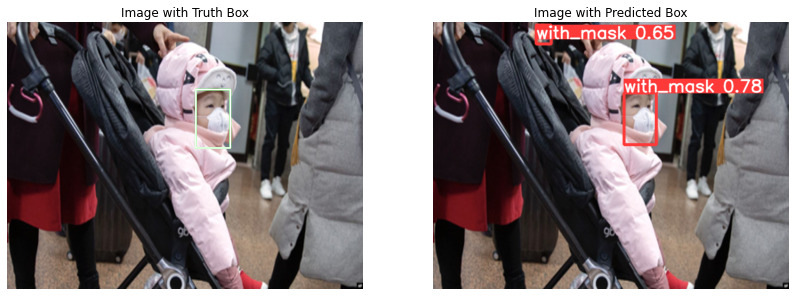

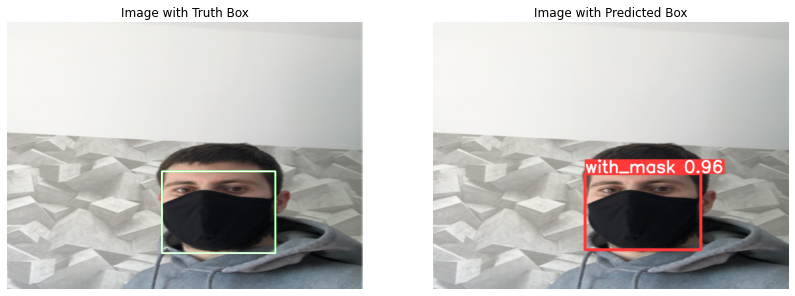

In [ ]:
show_image('maksssksksss102') 
show_image('maksssksksss117') 
plt.show()

In [ ]:
# 学習済みモデル
model = torch.hub.load('ultralytics/yolov5', 'custom', path='runs/train/exp3/weights/best.pt', device='cpu')

Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
requirements: PyYAML>=5.3.1 not found and is required by YOLOv5, attempting auto-update...

requirements: 1 package updated per /content/yolov5/requirements.txt
requirements: ⚠️ Restart runtime or rerun command for updates to take effect

YOLOv5 🚀 v6.1-163-gb53917d torch 1.11.0+cu113 CPU

Fusing layers... 
Model summary: 213 layers, 7018216 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 


In [ ]:
from PIL import Image

In [ ]:
from glob import glob
paths = sorted(glob('data/test/images/*.png'))

In [ ]:
imgs = []
for p in paths:
    img = Image.open(p)
    imgs.append(img)

In [ ]:
len(imgs)

25

In [ ]:
results = model(imgs, size=640)

In [ ]:
len(results)

25

In [ ]:
results.print()

image 1/25: 480x640 2 with_masks
image 2/25: 480x640 1 with_mask
image 3/25: 480x640 7 without_masks
image 4/25: 480x640 3 without_masks
image 5/25: 480x640 4 with_masks, 1 without_mask
image 6/25: 480x640 7 with_masks
image 7/25: 480x640 1 with_mask
image 8/25: 480x640 1 without_mask
image 9/25: 480x640 7 with_masks
image 10/25: 480x640 32 with_masks
image 11/25: 480x640 3 with_masks, 1 without_mask
image 12/25: 480x640 8 with_masks, 9 without_masks
image 13/25: 480x640 4 with_masks
image 14/25: 480x640 16 with_masks, 5 without_masks
image 15/25: 480x640 1 with_mask
image 16/25: 480x640 1 with_mask
image 17/25: 480x640 1 with_mask
image 18/25: 480x640 2 with_masks
image 19/25: 480x640 5 with_masks, 2 without_masks
image 20/25: 480x640 1 without_mask
image 21/25: 480x640 9 with_masks
image 22/25: 480x640 7 with_masks
image 23/25: 480x640 1 with_mask
image 24/25: 480x640 1 with_mask
image 25/25: 480x640 5 with_masks
Speed: 25.9ms pre-process, 313.5ms inference, 1.1ms NMS per image at sh

In [ ]:
# results.xyxy[0]

In [ ]:
import pandas as pd

In [ ]:
results_df = pd.DataFrame()
for p, n in zip(paths, range(len(results))):
    df_ = results.pandas().xyxy[n]
    p = p.replace('data/test/images/', '')
    p = p.replace('.png', '')
    df_['path'] = p
    results_df = pd.concat([results_df, df_])
results_df.reset_index(drop=True)

,xmin,ymin,xmax,ymax,confidence,class,name,path
0,342.870758,126.946487,400.551483,219.864914,0.782481,0,with_mask,maksssksksss102
1,184.777985,4.586975,211.562622,38.822174,0.653822,0,with_mask,maksssksksss102
2,273.143738,272.095123,480.840820,409.250580,0.964706,0,with_mask,maksssksksss117
3,144.604660,65.604950,193.061172,116.956207,0.899693,2,without_mask,maksssksksss121
4,382.483917,88.885384,423.858185,129.479401,0.896138,2,without_mask,maksssksksss121
...,...,...,...,...,...,...,...,...
143,173.831757,95.323898,280.287628,245.321121,0.937874,0,with_mask,maksssksksss91
144,390.472656,139.161362,499.295105,300.622681,0.905453,0,with_mask,maksssksksss91
145,469.360474,210.884583,552.166687,380.362244,0.833239,0,with_mask,maksssksksss91
146,319.052887,0.665493,404.339813,81.675613,0.429323,0,with_mask,maksssksksss91
